# Fine tuning of k-Nearest Neighbors model

## for binary classification

In [1]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, average_precision_score, classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)

# models
from sklearn.neighbors import KNeighborsClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/binary'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 10)
(2026, 10)
(8103,)
(2026,)


In [3]:
# numeric features that need transformation
real_features = ['mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound', 'co2', 'co2slope']

# scorer: Area under Precision-Recall curve (PR-AUC)
scorer = make_scorer(score_func=average_precision_score)

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
# kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

### Tuning without PCA

In [4]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = KNeighborsClassifier()

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(estimator, param_grid, factor=2, cv=kf, scoring=scorer, refit=True, verbose=1)
    search.fit(X_train, y_train)
        
    return search

In [5]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(subset=['param_model__n_neighbors', 'param_model__weights', 'param_model__p'], keep='last')
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    for p in df['param_model__p'].unique():
        print(f'p = {p}')
        
        df_p = df[df['param_model__p'] == p]
        data = df_p.pivot(index='param_model__n_neighbors', columns='param_model__weights', values='mean_test_score')
        annot = df_p.pivot(index='param_model__n_neighbors', columns='param_model__weights', values='rank')    

        sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot)
        plt.show()

In [7]:
param_grid = {
    'model__n_neighbors': [1, 3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

search = get_search_results(X_train, y_train, param_grid) # TODO: rename: results=...

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 506
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 506
Fitting 50 folds for each of 24 candidates, totalling 1200 fits
----------
iter: 1
n_candidates: 12
n_resources: 1012
Fitting 50 folds for each of 12 candidates, totalling 600 fits
----------
iter: 2
n_candidates: 6
n_resources: 2024
Fitting 50 folds for each of 6 candidates, totalling 300 fits
----------
iter: 3
n_candidates: 3
n_resources: 4048
Fitting 50 folds for each of 3 candidates, totalling 150 fits
----------
iter: 4
n_candidates: 2
n_resources: 8096
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__n_neighbors': 1, 'model__p': 1, 'model__weights': 'distance'}

Best score:
0.9980336355858092

p = 2


C:\Users\Judit\AppData\Local\Temp\ipykernel_12000\161746729.py:18: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_p.pivot(index='param_model__n_neighbors', columns='param_model__weights', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_12000\161746729.py:19: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_p.pivot(index='param_model__n_neighbors', columns='param_model__weights', values='rank')


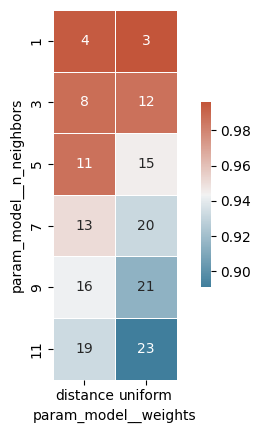

p = 1


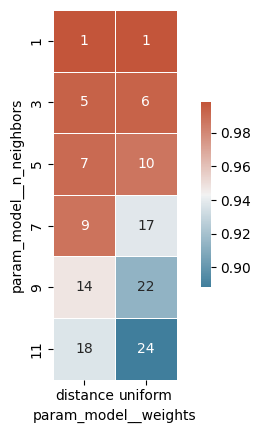

In [14]:
results = search
report_results(results)

## Best model cross-validation performance

In [15]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9980
Median: 0.9984
95% confidence interval: (0.9934 - 1.0000)


## Evaluate best model on hold-out test dataset

In [16]:
y_pred = results.best_estimator_.predict(X_test)

In [17]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      1646
           1     1.0000    0.9974    0.9987       380

    accuracy                         0.9995      2026
   macro avg     0.9997    0.9987    0.9992      2026
weighted avg     0.9995    0.9995    0.9995      2026



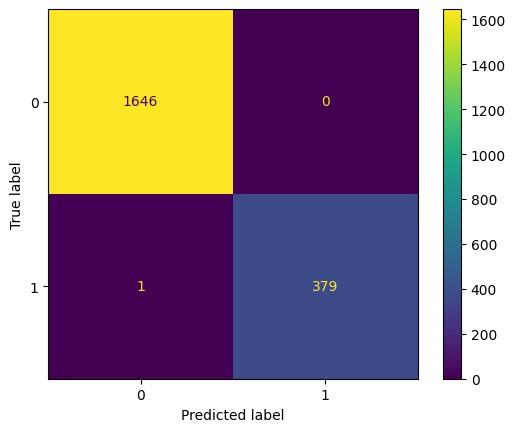

In [18]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

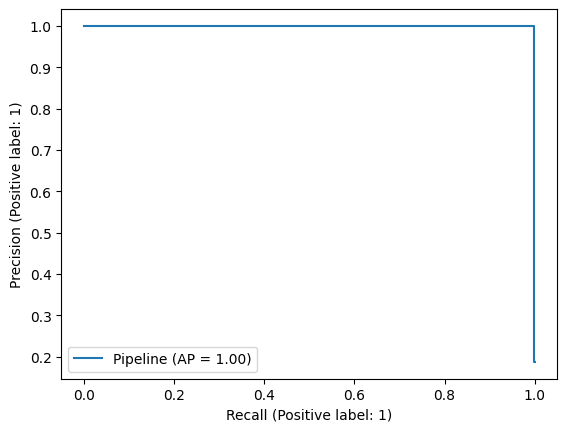

In [19]:
# Precision - Recall curve
PrecisionRecallDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

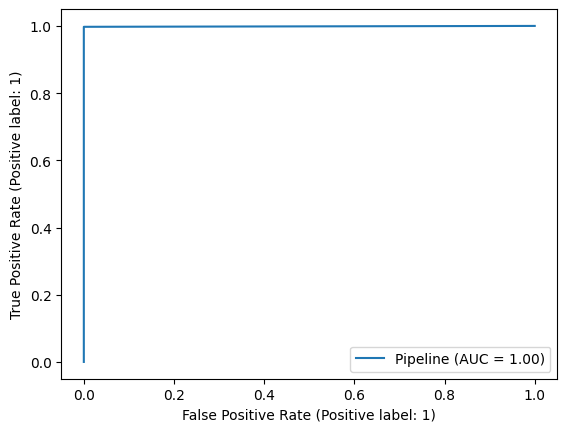

In [20]:
# ROC curve
RocCurveDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()